<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 12813, '日付': '2022-01-25T08:00:00.000Z'},
 {'小計': 14086, '日付': '2022-01-26T08:00:00.000Z'},
 {'小計': 16538, '日付': '2022-01-27T08:00:00.000Z'},
 {'小計': 17631, '日付': '2022-01-28T08:00:00.000Z'},
 {'小計': 17433, '日付': '2022-01-29T08:00:00.000Z'},
 {'小計': 15895, '日付': '2022-01-30T08:00:00.000Z'},
 {'小計': 11751, '日付': '2022-01-31T08:00:00.000Z'},
 {'小計': 14445, '日付': '2022-02-01T08:00:00.000Z'},
 {'小計': 21576, '日付': '2022-02-02T08:00:00.000Z'},
 {'小計': 20679, '日付': '2022-02-03T08:00:00.000Z'},
 {'小計': 19798, '日付': '2022-02-04T08:00:00.000Z'},
 {'小計': 21122, '日付': '2022-02-05T08:00:00.000Z'},
 {'小計': 17526, '日付': '2022-02-06T08:00:00.000Z'},
 {'小計': 12211, '日付': '2022-02-07T08:00:00.000Z'},
 {'小計': 17113, '日付': '2022-02-08T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2022-02-04 17:00:00+09:00,2219,0,19798,2022-02-04 17:00:00+09:00
2022-02-05 17:00:00+09:00,2246,0,21122,2022-02-05 17:00:00+09:00
2022-02-06 17:00:00+09:00,1910,0,17526,2022-02-06 17:00:00+09:00
2022-02-07 17:00:00+09:00,2232,0,12211,2022-02-07 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2022-02-04 17:00:00+09:00,2219,0,19798,2022-02-04 17:00:00+09:00,2531.714286,17722.0,0.0,0.0,17368.142857,121577.0
2022-02-05 17:00:00+09:00,2246,0,21122,2022-02-05 17:00:00+09:00,2394.142857,16759.0,0.0,0.0,17895.142857,125266.0
2022-02-06 17:00:00+09:00,1910,0,17526,2022-02-06 17:00:00+09:00,2316.714286,16217.0,0.0,0.0,18128.142857,126897.0
2022-02-07 17:00:00+09:00,2232,0,12211,2022-02-07 17:00:00+09:00,2167.428571,15172.0,0.0,0.0,18193.857143,127357.0
2022-02-08 17:00:00+09:00,0,0,17113,2022-02-08 17:00:00+09:00,1822.428571,12757.0,0.0,0.0,18575.000000,130025.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2022-01-25 17:00:00+09:00,2600,0,12813,2022-01-25 17:00:00+09:00,2415.428571,16908.0,0.0,0.0,9675.000000,67725.0,'22w04,Tue
2022-01-26 17:00:00+09:00,2517,0,14086,2022-01-26 17:00:00+09:00,2458.142857,17207.0,0.0,0.0,10633.428571,74434.0,'22w04,Wed
2022-01-27 17:00:00+09:00,2420,0,16538,2022-01-27 17:00:00+09:00,2516.142857,17613.0,0.0,0.0,11762.000000,82334.0,'22w04,Thu
2022-01-28 17:00:00+09:00,2586,0,17631,2022-01-28 17:00:00+09:00,2600.714286,18205.0,0.0,0.0,12895.142857,90266.0,'22w04,Fri
2022-01-29 17:00:00+09:00,3209,0,17433,2022-01-29 17:00:00+09:00,2673.428571,18714.0,0.0,0.0,13781.714286,96472.0,'22w04,Sat
2022-01-30 17:00:00+09:00,2452,0,15895,2022-01-30 17:00:00+09:00,2674.285714,18720.0,0.0,0.0,14699.857143,102899.0,'22w04,Sun
2022-01-31 17:00:00+09:00,3277,0,11751,2022-01-31 17:00:00+09:00,2723.000000,19061.0,0.0,0.0,15163.857143,106147.0,'22w05,Mon
2022-02-01 17:00:00+09:00,2415,0,14445,2022-02-01 17:00:00+09:00,2696.571429,18876.0,0.0,0.0,15397.000000,107779.0,'22w05,Tue
2022-02-02 17:00:00+09:00,2107,0,21576,2022-02-02 17:00:00+09:00,2638.000000,18466.0,0.0,0.0,16467.000000,115269.0,'22w05,Wed
2022-02-03 17:00:00+09:00,2043,0,20679,2022-02-03 17:00:00+09:00,2584.142857,18089.0,0.0,0.0,17058.571429,119410.0,'22w05,Thu


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2022-01-23 17:00:00+09:00,7901.857143,55313
2022-01-30 17:00:00+09:00,14699.857143,102899
2022-02-06 17:00:00+09:00,18128.142857,126897
2022-02-08 17:00:00+09:00,14662.000000,29324
2022-01-02 17:00:00+09:00,81.500000,163


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2022-01-25 17:00:00+09:00,2600,0,12813,2022-01-25 17:00:00+09:00,2415.428571,16908.0,0.0,0.0,9675.000000,67725.0,'22w04,Tue,NaN,NaN
2022-01-26 17:00:00+09:00,2517,0,14086,2022-01-26 17:00:00+09:00,2458.142857,17207.0,0.0,0.0,10633.428571,74434.0,'22w04,Wed,NaN,NaN
2022-01-27 17:00:00+09:00,2420,0,16538,2022-01-27 17:00:00+09:00,2516.142857,17613.0,0.0,0.0,11762.000000,82334.0,'22w04,Thu,NaN,NaN
2022-01-28 17:00:00+09:00,2586,0,17631,2022-01-28 17:00:00+09:00,2600.714286,18205.0,0.0,0.0,12895.142857,90266.0,'22w04,Fri,NaN,NaN
2022-01-29 17:00:00+09:00,3209,0,17433,2022-01-29 17:00:00+09:00,2673.428571,18714.0,0.0,0.0,13781.714286,96472.0,'22w04,Sat,NaN,NaN
2022-01-30 17:00:00+09:00,2452,0,15895,2022-01-30 17:00:00+09:00,2674.285714,18720.0,0.0,0.0,14699.857143,102899.0,'22w04,Sun,14699.857143,102899.0
2022-01-31 17:00:00+09:00,3277,0,11751,2022-01-31 17:00:00+09:00,2723.000000,19061.0,0.0,0.0,15163.857143,106147.0,'22w05,Mon,NaN,NaN
2022-02-01 17:00:00+09:00,2415,0,14445,2022-02-01 17:00:00+09:00,2696.571429,18876.0,0.0,0.0,15397.000000,107779.0,'22w05,Tue,NaN,NaN
2022-02-02 17:00:00+09:00,2107,0,21576,2022-02-02 17:00:00+09:00,2638.000000,18466.0,0.0,0.0,16467.000000,115269.0,'22w05,Wed,NaN,NaN
2022-02-03 17:00:00+09:00,2043,0,20679,2022-02-03 17:00:00+09:00,2584.142857,18089.0,0.0,0.0,17058.571429,119410.0,'22w05,Thu,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

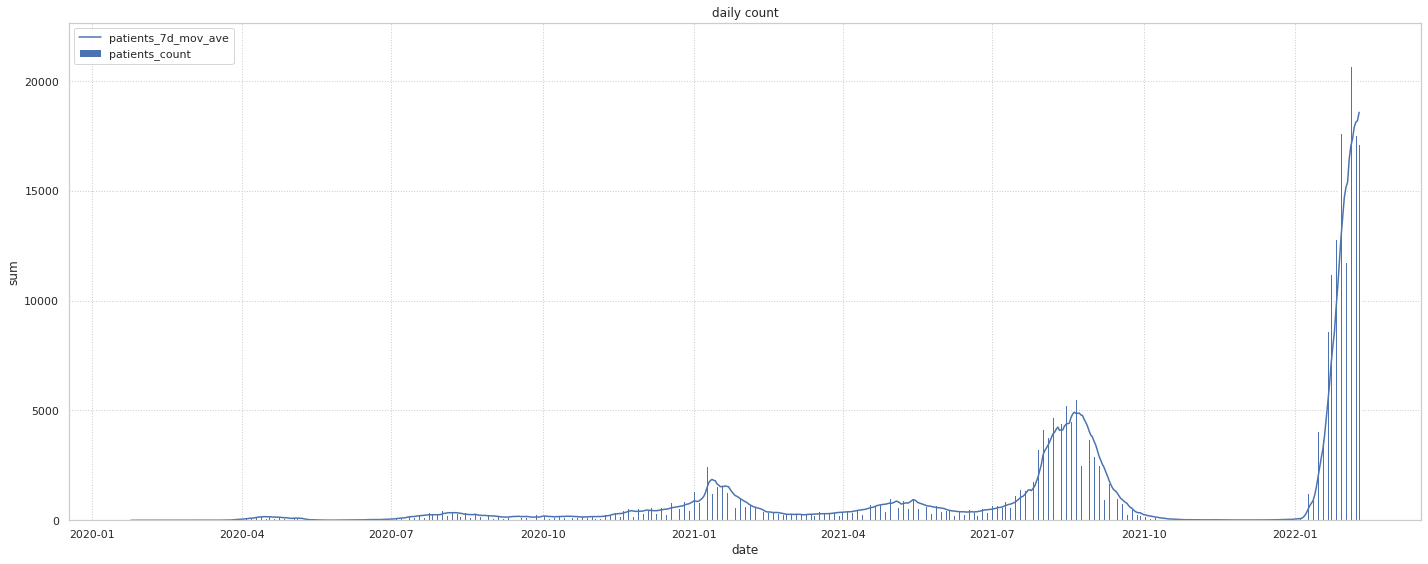

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
732,1.643098e+09,2022,1,25,0,0,0,0,0,1,0,732,0,658,2600,2415.428571,16908.0,0,0.0,0.0,12813,9675.000000,67725.0
733,1.643184e+09,2022,1,26,0,0,0,0,0,0,1,733,0,659,2517,2458.142857,17207.0,0,0.0,0.0,14086,10633.428571,74434.0
734,1.643270e+09,2022,1,27,0,0,0,0,1,0,0,734,0,660,2420,2516.142857,17613.0,0,0.0,0.0,16538,11762.000000,82334.0
735,1.643357e+09,2022,1,28,1,0,0,0,0,0,0,735,0,661,2586,2600.714286,18205.0,0,0.0,0.0,17631,12895.142857,90266.0
736,1.643443e+09,2022,1,29,0,0,1,0,0,0,0,736,0,662,3209,2673.428571,18714.0,0,0.0,0.0,17433,13781.714286,96472.0
737,1.643530e+09,2022,1,30,0,0,0,1,0,0,0,737,0,663,2452,2674.285714,18720.0,0,0.0,0.0,15895,14699.857143,102899.0
738,1.643616e+09,2022,1,31,0,1,0,0,0,0,0,738,0,664,3277,2723.000000,19061.0,0,0.0,0.0,11751,15163.857143,106147.0
739,1.643702e+09,2022,2,1,0,0,0,0,0,1,0,739,0,665,2415,2696.571429,18876.0,0,0.0,0.0,14445,15397.000000,107779.0
740,1.643789e+09,2022,2,2,0,0,0,0,0,0,1,740,0,666,2107,2638.000000,18466.0,0,0.0,0.0,21576,16467.000000,115269.0
741,1.643875e+09,2022,2,3,0,0,0,0,1,0,0,741,0,667,2043,2584.142857,18089.0,0,0.0,0.0,20679,17058.571429,119410.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            747 non-null    float64
 1   year                 747 non-null    int64  
 2   month                747 non-null    int64  
 3   day                  747 non-null    int64  
 4   Fri                  747 non-null    uint8  
 5   Mon                  747 non-null    uint8  
 6   Sat                  747 non-null    uint8  
 7   Sun                  747 non-null    uint8  
 8   Thu                  747 non-null    uint8  
 9   Tue                  747 non-null    uint8  
 10  Wed                  747 non-null    uint8  
 11  passed               747 non-null    int64  
 12  emergency            747 non-null    int64  
 13  em_passed            747 non-null    int64  
 14  contacts_count       747 non-null    int64  
 15  contacts_7d_mov_ave  747 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,7.470000e+02,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000
mean,1.612080e+09,2020.593039,6.412316,15.744311,0.143240,0.143240,0.143240,0.143240,0.141901,0.143240,0.141901,373.000000,0.065596,302.714859,670.846051,664.723433,4653.058902,493.331995,493.331995,3453.323963,966.871486,898.510098,6289.548862
std,1.864379e+07,0.588409,3.492045,8.882625,0.350552,0.350552,0.350552,0.350552,0.349182,0.350552,0.349182,215.784615,0.247740,210.095134,561.267399,543.107642,3801.759749,791.867147,726.490866,5085.436060,2617.390870,2345.582084,16419.082953
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.595966e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,186.500000,0.000000,112.500000,318.500000,322.500000,2257.500000,0.000000,0.000000,0.000000,47.000000,46.857143,328.000000
50%,1.612080e+09,2021.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,373.000000,0.000000,299.000000,505.000000,498.571429,3490.000000,0.000000,0.000000,0.000000,248.000000,258.714286,1811.000000
75%,1.628194e+09,2021.000000,9.000000,23.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,559.500000,0.000000,485.500000,805.500000,802.785714,5619.500000,984.500000,1051.214286,7358.500000,618.500000,629.928571,4409.500000
max,1.644307e+09,2022.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,746.000000,1.000000,672.000000,3277.000000,2723.000000,19061.000000,4060.000000,2574.142857,18019.000000,21576.000000,18575.000000,130025.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.877245,0.255858,-0.001159,-0.003792,0.001896,-0.001896,-3.048652e-16,0.000943,0.003792,-0.000943,1.000000e+00,-0.337889,0.998472,-0.077267,-0.082294,-0.082292,-0.618110,-0.664280,-0.664280,0.385026,0.384581,0.384583
year,8.772447e-01,1.000000,-0.237895,-0.044300,-0.002958,0.003541,0.003541,3.540818e-03,-0.005625,0.003541,-0.005625,8.772447e-01,-0.267218,0.883156,0.045453,0.037490,0.037492,-0.628742,-0.685322,-0.685322,0.498567,0.489549,0.489550
month,2.558576e-01,-0.237895,1.000000,0.003922,-0.002319,-0.003414,-0.011079,-7.794266e-03,0.013516,0.000966,0.010218,2.558576e-01,-0.144417,0.240707,-0.250688,-0.243599,-0.243596,0.016780,0.038363,0.038363,-0.227537,-0.209367,-0.209364
day,-1.158836e-03,-0.044300,0.003922,1.000000,0.007473,0.001446,0.000585,7.472856e-03,-0.002549,-0.005442,-0.009031,-1.158836e-03,-0.001505,-0.000576,0.025785,0.010267,0.010265,0.006236,-0.004438,-0.004438,-0.000996,-0.011294,-0.011295
Fri,-3.792297e-03,-0.002958,-0.002319,0.007473,1.000000,-0.167188,-0.167188,-1.671875e-01,-0.166275,-0.167187,-0.166275,-3.792297e-03,-0.000289,-0.003321,-0.015054,-0.003162,-0.003162,0.025668,-0.000742,-0.000742,0.014833,-0.004354,-0.004355
Mon,1.896148e-03,0.003541,-0.003414,0.001446,-0.167188,1.000000,-0.167188,-1.671875e-01,-0.166275,-0.167188,-0.166275,1.896148e-03,-0.000289,0.001920,0.039103,0.003263,0.003264,0.103502,-0.000742,-0.000742,-0.047156,0.007489,0.007489
Sat,-1.896148e-03,0.003541,-0.011079,0.000585,-0.167188,-0.167188,1.000000,-1.671875e-01,-0.166275,-0.167187,-0.166275,-1.896148e-03,-0.000289,-0.001574,0.043709,-0.000903,-0.000903,-0.120940,-0.000742,-0.000742,0.020141,0.000565,0.000564
Sun,-3.048652e-16,0.003541,-0.007794,0.007473,-0.167188,-0.167188,-0.167188,1.000000e+00,-0.166275,-0.167188,-0.166275,-3.066039e-16,-0.000289,0.000173,-0.019652,0.001018,0.001019,-0.111480,-0.000742,-0.000742,-0.008059,0.004646,0.004646
Thu,9.428972e-04,-0.005625,0.013516,-0.002549,-0.166275,-0.166275,-0.166275,-1.662746e-01,1.000000,-0.166275,-0.165367,9.428972e-04,0.000726,0.000443,-0.009587,-0.000717,-0.000716,0.032223,0.001862,0.001862,0.019828,-0.007531,-0.007531
Tue,3.792297e-03,0.003541,0.000966,-0.005442,-0.167187,-0.167188,-0.167187,-1.671875e-01,-0.166275,1.000000,-0.166275,3.792297e-03,-0.000289,0.003668,-0.025007,0.003263,0.003264,0.040885,-0.000742,-0.000742,-0.003555,0.011475,0.011475


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,1.643962e+09,1,0,0,0,0,0,0,742,0,668,2219,0,19798,17368.142857,121577.0
743,1.644048e+09,0,0,1,0,0,0,0,743,0,669,2246,0,21122,17895.142857,125266.0
744,1.644134e+09,0,0,0,1,0,0,0,744,0,670,1910,0,17526,18128.142857,126897.0
745,1.644221e+09,0,1,0,0,0,0,0,745,0,671,2232,0,12211,18193.857143,127357.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
742,1.643962e+09,742,0,19798,17368.142857,121577.0
743,1.644048e+09,743,0,21122,17895.142857,125266.0
744,1.644134e+09,744,0,17526,18128.142857,126897.0
745,1.644221e+09,745,0,12211,18193.857143,127357.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

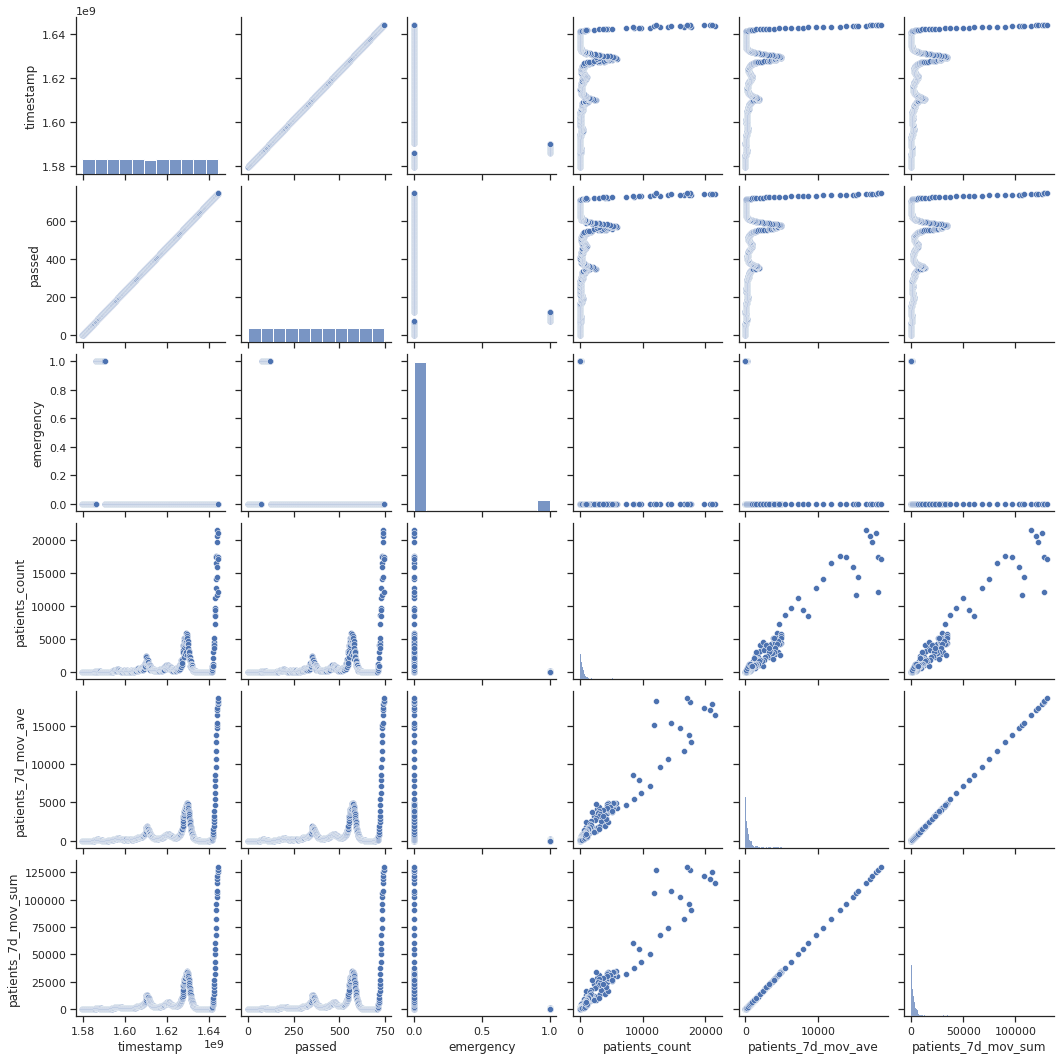

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.12


In [30]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.2
chardet==3.0.4
charset-normalizer==2.0.11
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.27
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed==